In [37]:
import importlib
import numpy as np
import pipeline
from importlib import reload

reload(pipeline)

<module 'pipeline' from 'C:\\Users\\einkina\\Documents\\School\\Manifold Learning\\manifold-learning\\pipeline.py'>

In [38]:
reload(pipeline)
control_vars = pipeline.get_control_vars(pipeline.get_p())
response_matrix = pipeline.generate_array_of_swiss_rolls(control_vars)
(standardized_x, centered_y, ld_embedding, regression_matrix, \
                        y_means, y_scaler, x_means, x_stds) = \
    pipeline.maximum_covariance_unfolding_regression(control_vars, response_matrix)
reconstructed_y = np.dot(standardized_x, regression_matrix)

print(pipeline.compute_rre(ld_embedding, reconstructed_y))

0.04679522695047815


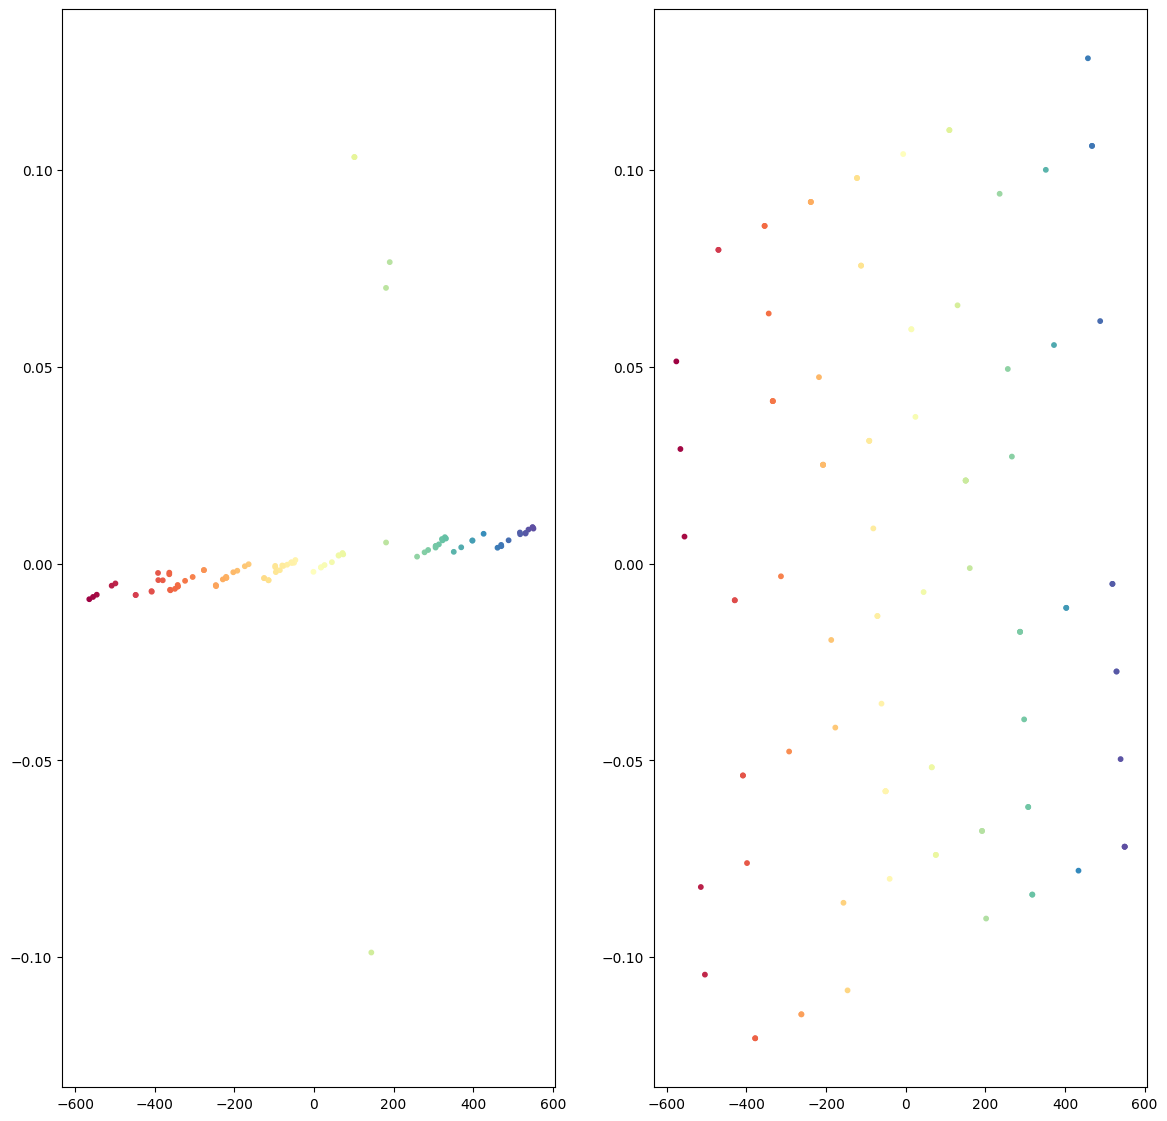

In [39]:
reload(pipeline)
pipeline.plot_two_embeddings(ld_embedding, reconstructed_y)

In [40]:
reload(pipeline)
test_control_vars = pipeline.get_control_vars(pipeline.get_p())
test_rolls = pipeline.generate_array_of_swiss_rolls(test_control_vars, 10)
for (roll, control_var) in zip(test_rolls, test_control_vars):
    x_opt, x_err = pipeline.predictive_optimization(roll, centered_y, ld_embedding, regression_matrix, y_means, y_scaler)
    x_opt = x_opt * x_stds + x_means
    print("-----------")
    print(f"x_opt  = {x_opt}, x_err = {x_err}")
    print(f"x_real = {control_var}")

-----------
x_opt  = [6.64970214 5.91354247], x_err = 9.163827270149675e-12
x_real = [10, 5]
-----------
x_opt  = [9.64072857 5.85451627], x_err = 2.6320816737154228e-14
x_real = [3, 6]
-----------
x_opt  = [11.03708371  1.74889359], x_err = 1.0520210966213558e-11
x_real = [10, 2]
-----------
x_opt  = [2.34975667 9.40620429], x_err = 4.375560351945891e-12
x_real = [1, 9]
-----------
x_opt  = [9.88412017 3.30802737], x_err = 9.772120835237686e-12
x_real = [1, 2]
-----------
x_opt  = [4.56100619 7.85578671], x_err = 8.414081575914585e-12
x_real = [5, 7]
-----------
x_opt  = [1.17651373 9.48209729], x_err = 8.631050373000624e-12
x_real = [4, 9]
-----------
x_opt  = [10.50399705  9.75979054], x_err = 1.1537795892262456e-11
x_real = [9, 8]
-----------
x_opt  = [3.32126894 7.6672261 ], x_err = 9.008368966233874e-12
x_real = [2, 7]
-----------
x_opt  = [1.7934921  5.62400535], x_err = 1.083089154191604e-11
x_real = [8, 7]
